# Load data

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

# Clean data

In [8]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'd57004c0eb2f4779ba9b2b08d64bdcbd')

In [9]:
results = search_images_bing(key, 'bengal cat')
ims = results.attrgot('contentUrl')
len(ims)

150

In [12]:
cat_types = 'Bengal','Siamese','Maine Coon'
path = Path('cats')

In [13]:
if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [14]:
fns = get_image_files(path)
fns

(#427) [Path('cats/Siamese/00000016.jpg'),Path('cats/Siamese/00000028.jpg'),Path('cats/Siamese/00000007.jpg'),Path('cats/Siamese/00000076.jpg'),Path('cats/Siamese/00000119.jpg'),Path('cats/Siamese/00000068.jpg'),Path('cats/Siamese/00000127.jpg'),Path('cats/Siamese/00000005.jpg'),Path('cats/Siamese/00000148.jpg'),Path('cats/Siamese/00000030.jpg')...]

In [15]:
failed = verify_images(fns)
failed

(#3) [Path('cats/Siamese/00000044.jpeg'),Path('cats/Maine Coon/00000117.jpg'),Path('cats/Bengal/00000082.jpg')]

In [16]:
failed.map(Path.unlink);

# Load data

In [36]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [37]:
dls = cats.dataloaders(path)

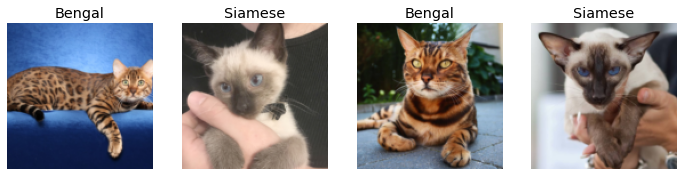

In [38]:
dls.valid.show_batch(max_n=4, nrows=1)

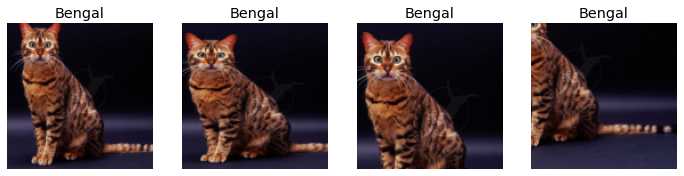

In [39]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# train model / clean data

In [40]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [41]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.431379,0.230250,0.071429,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.165117,0.122196,0.047619,00:09
1,0.108302,0.102266,0.023810,00:10
2,0.080464,0.109600,0.035714,00:10
3,0.062769,0.110371,0.035714,00:09


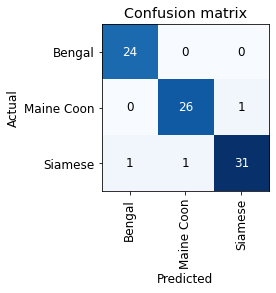

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

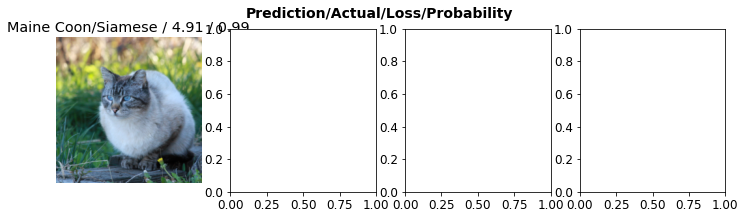

In [47]:
interp.plot_top_losses(4, nrows=1)

In [44]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [45]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# export to cat.pk1

In [48]:
learn.export('cat.pkl')

In [49]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('cat.pkl')]